In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, os, random
import numpy as np
import json
import argparse
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from PIL import Image
from threading import Thread

In [18]:
argtrain = 'y'
argepoch = 100
argmodel = 'googlenet'
arglabel = 'flower_to_name.json'
argdir = os.path.expanduser('~') + '/Programming Data/Flower_data/'
arglearn = 0.003
arglayer = 3

# 'vgg', 'alexnet', 'googlenet', 'densenet', 'inception', 'resnext', 'shufflenet'

In [3]:
# from cnn_utility_functions import *

def u1_get_input_args():
    """
    Creates and stores command line arguments inputted by the user. Attaches default arguments and help text to aid user.
    Command Line Arguments:
        1. Directory as --dir
        2. CNN Model as --model
        3. Data Name Dictionary as --names
    This function returns these arguments as an ArgumentParser object.
    Parameters:
        - None
    Returns:
        - Stored command line arguments as an Argument Parser Object with parse_args() data structure
    """

    parser = argparse.ArgumentParser(description = 'Classify input images and benchmark performance')
    parser.add_argument('--dir', type=str, default= os.path.expanduser('~')+'/Programming Data/Flower_data/', help='input path for data directory')
    parser.add_argument('--train', type=str, default='n', help='yes \'y\' or no \'n\' to retrain this model', choices=['y','n'])
    parser.add_argument('--epoch', type=str, default=100, help='provide the number of epochs for training (default 100)')
    parser.add_argument('--layer', type=str, default=2, help='provide the number of hidden layers to use (default 2)')
    parser.add_argument('--learn', type=str, default=0.003, help='provide the learning rate to begin training (default 0.003)')
    parser.add_argument('--label', type=str, default='', help='flower_to_name.json')
    parser.add_argument('--model', type=str, default='googlenet', help='select pretrained model',
                        choices=['vgg', 'alexnet', 'googlenet', 'densenet', 'resnext', 'shufflenet'])

    return parser.parse_args() #return parsed arguments


def u2_load_processed_data(data_dir):
    """
    Receives a pathway to a folder containing training, .
    Command Line Arguments:
        1. Directory as --dir
        2. CNN Model as --model
        3. Data Name Dictionary as --names
    This function returns these arguments as an ArgumentParser object.
    Parameters:
        - None
    Returns:
        - Stored command line arguments as an Argument Parser Object with parse_args() data structure
    """

    dict_datasets = {}
    for folder in os.listdir(data_dir):
        if os.path.splitext(folder)[1] == '' and folder != 'predict':
            dict_datasets[folder + '_data'] = datasets.ImageFolder(data_dir + folder, transform=u3_process_data(folder))
        if os.path.splitext(folder)[1] == '' and folder == 'predict':
            predict_transform = u3_process_data(folder)
            dict_datasets['predict_data'] = [(predict_transform(Image.open(data_dir + folder + '/' + filename)), filename) for filename in os.listdir(data_dir + folder)]
        if os.path.splitext(folder)[1] == '.json':
            with open(data_dir + folder, 'r') as f:
                dict_data_labels = json.load(f)
    dict_class_labels = {value : key for (key, value) in dict_datasets['train_data'].class_to_idx.items()}
    return dict_datasets, dict_data_labels, dict_class_labels


def u3_process_data(transform_request):
    #Define transforms for training, validation, overfitting, and test sets to convert to desirable tensors for processing

    #Define image size
    image_1d_size = 224

    train_transform = transforms.Compose([transforms.RandomRotation(20),
                                          transforms.RandomResizedCrop(image_1d_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

    valid_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                          transforms.CenterCrop(image_1d_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    test_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                         transforms.CenterCrop(image_1d_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    game_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                         transforms.CenterCrop(image_1d_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    predict_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                            transforms.CenterCrop(image_1d_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    inverse_transform = transforms.Compose([transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
                                            transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1])])

    overfit_transform = train_transform

    return locals()[transform_request + '_transform']


def u4_data_iterator(dict_datasets):
    '''
    # bug, requires every folder to run correctly. Consider removing this function and nesting it directly into training function!
    '''
    dict_data_loaders = {}
    dict_data_loaders['train_loader'] = torch.utils.data.DataLoader(dict_datasets['train_data'], batch_size=128, shuffle=True)
    dict_data_loaders['valid_loader'] = torch.utils.data.DataLoader(dict_datasets['valid_data'], batch_size=64, shuffle=True)
    dict_data_loaders['testing_loader'] = torch.utils.data.DataLoader(dict_datasets['test_data'], batch_size=32, shuffle=True)
    dict_data_loaders['overfit_loader'] = torch.utils.data.DataLoader(dict_datasets['overfit_data'], batch_size=8, shuffle=True)
    dict_data_loaders['predict_loader'] = torch.utils.data.DataLoader(dict_datasets['predict_data'], batch_size=2, shuffle=False)
    
    return dict_data_loaders


def u5_time_limited_input(prompt):
    TIMEOUT = 10
    prompt = prompt + f': \'y\' for yes, \'n\' for no ({TIMEOUT} seconds to choose): '
    user_input_thread = Thread(target=u6_user_input_prompt, args=(prompt,), daemon = True)
    user_input_thread.start()
    user_input_thread.join(TIMEOUT)
    if not answered:
        print('\n No valid input, proceeding with operation...')
    return choice


def u6_user_input_prompt(prompt, default=True):
    global choice, answered
    choice = default
    answered = False
    while not answered:
        choice = input(prompt)
        if choice == 'Y' or choice == 'y':
            print('User input = Yes\n')
            choice = True
            answered = True
        elif choice == 'N' or choice == 'n':
            choice = False
            answered = True
            print('User input = No\n')
        else:
            choice=choice
            print('Error, please use the character inputs \'Y\' and \'N\'')


# def u7_get_image(image_path):
#     ''' Process raw image for input to deep learning model
#     '''
#     image_open = Image.open(image_path) # access image at pathway, open the image and store it as a PIL image
#     tensor_image = flower_transform(image_open) # transform PIL image and simultaneously convert image to a tensor (no need for .clone().detach())
#     input_image = torch.unsqueeze(tensor_image, 0) # change image shape from a stand alone image tensor, to a list of image tensors with length = 1
#     return input_image # return processed image


# def u8_show_image():


In [4]:
# From cnn_operational_functions.py import *

def o1_train_model(model, dict_data_loaders, epoch, learnrate, type_loader, criterion):

    print("Using GPU" if torch.cuda.is_available() else "WARNING")
    t0 = time.time() # initialize start time for running training

    running_count = 0 # initialize running count in order to track number of epochs fine tuning deeper network
    running = False # initialize running variable to start system with deeper network frozen

    # Define default hyperparameters: learning rate and weight decay
    model_hyperparameters = {'learnrate': learnrate,
                         'training_loss_history': [],
                         'validate_loss_history': [],
                         'epoch_on': [],
                         'running_count': 0,
                         'weightdecay' : 0.00001}

    startlearn = model_hyperparameters['learnrate']

    # Only train the classifier (new_output) parameters, feature parameters are frozen
    optimizer = optim.Adam(getattr(model, list(model._modules.items())[-1][0]).parameters(), lr=model_hyperparameters['learnrate'], weight_decay=model_hyperparameters['weightdecay'])

    if type_loader == 'overfit_loader':
        decay = 0.9 # hyperparameter decay factor for decaying learning rate
        epoch = 200 # hyperparameter number of epochs

    if type_loader == 'train_loader':
        decay = 0.6 # hyperparameter decay factor for decaying learning rate

    for e in range(epoch):

        model, ave_training_loss = o2_model_backprop(model, dict_data_loaders[type_loader], optimizer, criterion)
        epoch_count_correct, ave_validate_loss = o3_model_no_backprop(model, dict_data_loaders['valid_loader'], criterion)

        model_hyperparameters['training_loss_history'].append(ave_training_loss) # append ave training loss to history of training losses
        model_hyperparameters['validate_loss_history'].append(ave_validate_loss) # append ave validate loss to history of validate losses

        print('Epoch: {}/{}.. '.format(e+1, epoch),
            'Train Loss: {:.3f}.. '.format(ave_training_loss),
            'Valid Loss: {:.3f}.. '.format(ave_validate_loss),
            'Valid Accuracy: {:.3f}.. '.format(epoch_count_correct / len(dict_data_loaders['valid_loader'].dataset)),
            'Runtime - {:.0f} mins'.format((time.time() - t0)/60))

        training_loss_history = model_hyperparameters['training_loss_history']
        if len(training_loss_history) > 3: # hold loop until training_loss_history has enough elements to satisfy search requirements
            if -3*model_hyperparameters['learnrate']*decay*decay*training_loss_history[0] > np.mean([training_loss_history[-2]-training_loss_history[-1], training_loss_history[-3]-training_loss_history[-2]]):
                # if the average of the last 2 training loss slopes is less than the original loss factored down by the learnrate, the decay, and a factor of 3, then decay the learnrate
                model_hyperparameters['learnrate'] *= decay # multiply learnrate by the decay hyperparameter
                optimizer = optim.Adam(getattr(model, list(model._modules.items())[-1][0]).parameters(), lr=model_hyperparameters['learnrate'], weight_decay=model_hyperparameters['weightdecay']) # revise the optimizer to use the new learnrate
                print('Learnrate changed to: {:f}'.format(model_hyperparameters['learnrate']))
            if model_hyperparameters['learnrate'] <= startlearn*decay**(9*(decay**3)) and model_hyperparameters['running_count'] == 0: # super messy, I wanted a general expression that chose when to activate the deeper network and this worked
                model = o4_control_model_grad(model, True)
                model_hyperparameters['epoch_on'] = e
                running = True # change the running parameter to True so that the future loop can start counting epochs that have run
            if running: # if running, add to count for the number of epochs run
                model_hyperparameters['running_count'] +=1
            if running and model_hyperparameters['running_count'] > epoch/5: # deactivate parameters if running, add the count has reached its limiter
                model = o4_control_model_grad(model, False)
                running = False
            if type_loader == 'overfit_loader':
                if np.mean([training_loss_history[-1], training_loss_history[-2], training_loss_history[-3]]) < 0.0002:
                    print('\nModel successfully overfit images\n')
                    return model, model_hyperparameters
                if e+1 == epoch:
                    print('\nModel failed to overfit images\n')

    return model, model_hyperparameters


def o2_model_backprop(model, data_loader, optimizer, criterion):
    # Check model can overfit the data when using a miniscule sample size, looking for high accuracy on a few images
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    model.to(device)

    epoch_train_loss = 0 # initialize total training loss for this epoch
    model.train() # Set model to training mode to activate operations such as dropout
    for images, labels in data_loader: # cycle through training data
        images, labels = images.to(device), labels.to(device) # move data to GPU

        optimizer.zero_grad() # clear gradient history
        log_out = model(images) # run image through model to get logarithmic probability
        loss = criterion(log_out, labels) # calculate loss (error) for this image batch based on criterion

        loss.backward() # backpropogate gradients through model based on error
        optimizer.step() # update weights in model based on calculated gradient information
        epoch_train_loss += loss.item() # add training loss to total train loss this epoch, convert to value with .item()
    ave_training_loss = epoch_train_loss / len(data_loader) # determine average loss per batch of training images

    return model, ave_training_loss


def o3_model_no_backprop(model, data_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    epoch_valid_loss = 0 # initialize total validate loss for this epoch
    epoch_count_correct = 0 # initialize total correct predictions on valid set
    model.eval() # set model to evaluate mode to deactivate generalizing operations such as dropout and leverage full model
    with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
        for images, labels in data_loader: # cycle through validate data to observe performance
            images, labels = images.to(device), labels.to(device) # move data to GPU

            log_out = model(images) # obtain the logarithmic probability from the model
            loss = criterion(log_out, labels) # calculate loss (error) for this image batch based on criterion
            epoch_valid_loss += loss.item() # add validate loss to total valid loss this epoch, convert to value with .item()

            out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
            highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greavalid calculated probability
            equals = chosen_class.view(labels.shape) == labels # determine how many correct matches were made in this batch
            epoch_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch

        ave_validate_loss = epoch_valid_loss / len(data_loader) # determine average loss per batch of validate images

    return epoch_count_correct, ave_validate_loss


def o4_control_model_grad(model, control=False):
    network_depth = len(list(model.children()))
    param_freeze_depth = network_depth // 2
    controlled_layers = []
    layer_depth = 0

    for layer in model.children():
        layer_depth += 1
        if (network_depth - param_freeze_depth) < layer_depth < network_depth:
            controlled_layers.append(layer._get_name())
            for param in layer.parameters():
                param.requires_grad = control
    print(f'\n Toggle requires_grad = {control}: ', controlled_layers, '\n')
    return model


def o5_plot_training_history(model_name, model_hyperparameters):
    plt.clf()
    plt.plot(model_hyperparameters['training_loss_history'], label='Training Training Loss')
    plt.plot(model_hyperparameters['validate_loss_history'], label='Validate Training Loss')
    if model_hyperparameters['epoch_on']:
        plt.vlines(
            colors = 'black',
            x = model_hyperparameters['epoch_on'],
            ymin = min(model_hyperparameters['training_loss_history']),
            ymax = max(model_hyperparameters['training_loss_history'][3:]),
            linestyles = 'dotted',
            label = 'Deep Layers Activated'
        ).set_clip_on(False)
        plt.vlines(
            colors = 'black',
            x = (model_hyperparameters['epoch_on'] + model_hyperparameters['running_count']),
            ymin = min(model_hyperparameters['training_loss_history']),
            ymax = max(model_hyperparameters['training_loss_history'][3:]),
            linestyles = 'dotted',
            label = 'Deep Layers Deactivated'
        ).set_clip_on(False)
    plt.title(model_name)
    plt.ylabel('Total Loss')
    plt.xlabel('Total Epoch ({})'.format(len(model_hyperparameters['training_loss_history'])))
    plt.legend(frameon=False)

In [5]:
# from cnn_model_functions import *

# Store a dictionary of available models as names to avoid downloading models until a choice has been made
model_name_dic = {'vgg': 'vgg16', 'alexnet': 'alexnet', 'googlenet': 'googlenet', 'densenet': 'densenet161',
                    'resnext': 'resnext50_32x4d', 'shufflenet': 'shufflenet_v2_x1_0'}


#Create a Classifier class, inheriting from nn.Module and incorporating Relu, Dropout and log_softmax
class Classifier(nn.Module):
    def __init__(self, in_features, hidden_layers, out_features):
        super().__init__()
        self.in_features = in_features
        self.hidden_layers = hidden_layers
        self.out_features = out_features
        self.layer = 1
        while self.layer < self.hidden_layers:
            setattr(self, 'fc'+str(self.layer), nn.Linear(round(self.in_features/(2**(self.layer-1))), round(self.in_features/(2**self.layer))))
            self.layer += 1
        setattr(self, 'fc'+str(self.layer), nn.Linear(round(self.in_features/(2**(self.layer-1))), self.out_features))
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        self.layer = 1
        while self.layer < self.hidden_layers:
            x = self.dropout(F.relu(getattr(self,'fc'+str(self.layer))(x)))
            self.layer += 1
        
        x = F.log_softmax(getattr(self,'fc'+str(self.layer))(x), dim=1)
        return x



def m1_create_classifier(model_name, hidden_layers, classes_length):

    #Download a pretrained convolutional neural network to reference, choose only the model requested by the user
    model = getattr(models, model_name_dic[model_name])(pretrained=True)
    #     print(model)
    
    # Ensure that the in and out features for our model seamlessly match the in from the pretrained CNN and the out for the classes
    # Rename the pretrained output layer to a default name 'new_output'
    # pretrained_output_name = list(model._modules.items())[-1][0]
    # model._modules['new_output'] = model._modules.pop(pretrained_output_name)
    out_features = classes_length
    for module in list(model.modules()):
        if module._get_name() == 'Linear':
            in_features = module.weight.shape[1]
            break
            
#     in_features = list(model.children())[-1].weight.shape[1]

#     model = torch.nn.Sequential(*(list(model.children())[:-1]))

#     Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    setattr(model, list(model._modules.items())[-1][0], Classifier(in_features, hidden_layers, out_features))
    
    return model


def m2_save_model_checkpoint(model, file_name_scheme, model_hyperparameters):
    #Save the model state_dict
    torch.save(model.state_dict(), file_name_scheme + '_dict.pth')

    #Create a JSON file containing the saved information above
    with open(file_name_scheme + '_hyperparameters.json', 'w') as file:
        json.dump(model_hyperparameters, file)


def m3_load_model_checkpoint(model, file_name_scheme):
    # Option to reload from previous state
    checkpoint = torch.load(file_name_scheme + '_dict.pth')
    model.load_state_dict(checkpoint)

    with open(file_name_scheme + '_hyperparameters.json', 'r') as file:
        model_hyperparameters = json.load(file)

    print('loaded model learnrate = ', model_hyperparameters['learnrate'])

    return model, model_hyperparameters


In [14]:
getattr(model, list(model._modules.items())[-1][0]).state_dict().keys()
list(model._modules.items())[-1][0]

'fc'

In [8]:
def o6_predict_data(model, image_path, topk=5):
    ''' Compute probabilities for various classes for an image using a trained deep learning model.
    '''
    model.eval()
    with torch.no_grad():
        input_image = get_image(image_path)
        prediction = torch.exp(model(input_image))
        probabilities, classes = prediction.topk(topk)
    return probabilities, classes

def u7_get_image(image_path):
    ''' Process raw image for input to deep learning model
    '''
    image_open = Image.open(image_path) # access image at pathway, open the image and store it as a PIL image
    tensor_image = flower_transform(image_open) # transform PIL image and simultaneously convert image to a tensor (no need for .clone().detach())
    input_image = torch.unsqueeze(tensor_image, 0) # change image shape from a stand alone image tensor, to a list of image tensors with length = 1
    return input_image # return processed image

In [9]:
# Record start time
start_program_time = time.time()

# Get processed data
dict_datasets, data_labels_dic, dict_labels = u2_load_processed_data(argdir)
dict_data_loaders = u4_data_iterator(dict_datasets)

#Create file pathway for hyperparameter saving to JSON format later
file_name_scheme = os.path.basename(os.path.dirname(argdir)) + '_' + argmodel
criterion = nn.NLLLoss()

# Download a classifer model for use
model = m1_create_classifier(argmodel, arglayer, len(dict_datasets['train_data'].classes))

# if argtrain == 'y':
# if u5_time_limited_input('Check model can overfit small dataset'):
overfit_model, model_hyperparameters = o1_train_model(model, dict_data_loaders, argepoch, arglearn, 'overfit_loader', criterion)
o5_plot_training_history(argmodel, model_hyperparameters)
plt.savefig(file_name_scheme + '_training_history_overfit.png')
print('Saved overfit training history to project directory')

# if u5_time_limited_input('Continue with complete model training'):
#     model, model_hyperparameters = o1_train_model(model, dict_data_loaders, argepoch, 'train_loader', criterion)
#     o5_plot_training_history(argmodel, model_hyperparameters)
#     plt.savefig(file_name_scheme + '_training_history_complete.png')
#     print('Saved complete training history to project directory')

#     if u5_time_limited_input('Would you like to test the model'):
t1 = time.time()
test_count_correct, ave_test_loss = o3_model_no_backprop(model, dict_data_loaders['testing_loader'], criterion)
print('testing Loss: {:.3f}.. '.format(ave_test_loss),
    'testing Accuracy: {:.3f}'.format(test_count_correct / len(dict_data_loaders['testing_loader'].dataset)),
    'Runtime - {:.0f} seconds'.format((time.time() - t1)))

#     #Save the model hyperparameters and the locations in which the CNN training activated and deactivated
#     if u5_time_limited_input('Would you like to save the model'):
#         m2_save_model_checkpoint(model, file_name_scheme, model_hyperparameters)

# if argtrain == 'n':
#     model, model_hyperparameters = m3_load_model_checkpoint(model, file_name_scheme)
#     o5_plot_training_history(argmodel, model_hyperparameters)
#     plt.show(block=False)
#     plt.pause(3)
#     plt.close()

#     learnrate = model_hyperparameters['learnrate']
#     training_loss_history = model_hyperparameters['training_loss_history']
#     validate_loss_history = model_hyperparameters['validate_loss_history']
#     epoch_on = model_hyperparameters['epoch_on']
#     running_count = model_hyperparameters['running_count']

#     print('The model is ready to provide predictions')

    #
    # o6_predict_data():
    #
    # u7_show_prediction():

Using GPU


KeyboardInterrupt: 

In [22]:
model_hyperparameters = {'training_loss_history': [],
                     'validate_loss_history': [],
                     'epoch_on': [],
                     'running_count': 0,
                     'weightdecay' : 0.00001,
                     'training_time' : 0}
'_training_history_overfit.png'
dir(model_hyperparameters)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [10]:
# Troubleshooter on param layer depth search
network_depth = len(list(model.children()))
param_freeze_depth = network_depth // 2
control = False

controlled_layers = []
layer_depth = 0

for layer in model.children():
    print(layer._get_name())
    layer_depth += 1
#     print(f'network_depth - param_freeze_depth = {network_depth - param_freeze_depth} < layer_depth = {layer_depth} < network_depth = {network_depth}')
    if (network_depth - param_freeze_depth) < layer_depth < network_depth:
        controlled_layers.append(layer._get_name())
#         for param in layer.parameters():
#             param.requires_grad = control

print(f'\n Toggle requires_grad = {control}: ', controlled_layers, '\n')

BasicConv2d
MaxPool2d
BasicConv2d
BasicConv2d
MaxPool2d
Inception
Inception
MaxPool2d
Inception
Inception
Inception
Inception
Inception
MaxPool2d
Inception
Inception
AdaptiveAvgPool2d
Dropout
Classifier

 Toggle requires_grad = False:  ['Inception', 'Inception', 'Inception', 'MaxPool2d', 'Inception', 'Inception', 'AdaptiveAvgPool2d', 'Dropout'] 



In [11]:
# Get processed data
dict_datasets, data_labels_dic, dict_class_labels = u2_load_processed_data(argdir)
dict_data_loaders = u4_data_iterator(dict_datasets)

argmodel = 'googlenet'
# argmodel = 'alexnet'
# argmodel = 'vgg'
arglayer = 3
model = m1_create_classifier(argmodel, arglayer, len(dict_datasets['train_data'].classes))

# model
print(list(model.children())[-1])

# list(model._modules.items())
# list(model.children())
# list(model.children())[-1]
# .weight.shape[1]

# in_features = list(model.children())[-1][1].weight.shape[1]
# list(model._modules.items())[-1][0]

image_1d_size = 224
predict_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                            transforms.CenterCrop(image_1d_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# plt.imshow(random.choice(dict_datasets['test_data'])[0].numpy().transpose((1, 2, 0)))


image_open = Image.open(dict_datasets['test_data'].imgs[0][0])
image_tensor = predict_transform(image_open)
# image_tensor
# plt.imshow(dict_datasets['test_data'][0].numpy().transpose((1, 2, 0)))
# torch.unsqueeze(image_tensor, 0)
dict_datasets['test_data'].imgs[0][0]
dict_datasets['test_data']
dict_data_loaders['testing_loader']
# t = u3_process_data('predict')(Image.open(argdir + 'predict'))


Classifier(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=102, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


[0 1]
0
1
[0]
0
[['corn poppy', 'pink-yellow dahlia', 'sweet william', 'spear thistle', 'foxglove'], [0.01128250639885664, 0.01116377767175436, 0.010945145972073078, 0.01086314395070076, 0.010789498686790466]]
{'balloonflower.jpeg': [['corn poppy', 'pink-yellow dahlia', 'sweet william', 'spear thistle', 'foxglove'], [0.01128250639885664, 0.01116377767175436, 0.010945145972073078, 0.01086314395070076, 0.010789498686790466]], 'balloonflower2.jpeg': [['corn poppy', 'sweet william', 'pink-yellow dahlia', 'foxglove', 'mexican aster'], [0.011474358849227428, 0.011255435645580292, 0.01096814963966608, 0.010934107936918736, 0.0108860544860363]], 'firelily.jpg': [['sweet william', 'mexican aster', 'pink-yellow dahlia', 'oxeye daisy', 'corn poppy'], [0.011137946508824825, 0.011079002171754837, 0.011057368479669094, 0.011036166921257973, 0.010950115509331226]]}


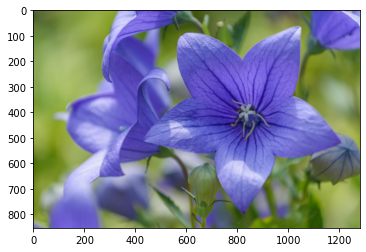

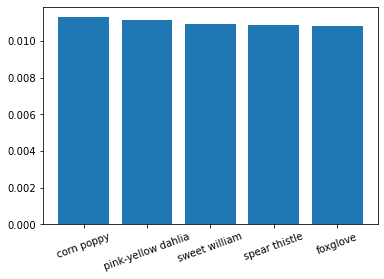

In [23]:
dict_datasets, dict_data_labels, dict_class_labels = u2_load_processed_data(argdir)
predict_transform = u3_process_data('predict')

dict_datasets['predict_data'] = [(predict_transform(Image.open(argdir + 'predict/' + filename)), filename) for filename in os.listdir(argdir + 'predict')]
dict_data_loaders['predict_loader'] = torch.utils.data.DataLoader(dict_datasets['predict_data'], batch_size=2, shuffle=False)


name = 'balloonflower.jpeg'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() 
results_dic = {}
with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
    for image, filenames in dict_data_loaders['predict_loader']:
        image = image.to(device)
        model_output = torch.exp(model(image))
        probabilities, class_indexes = model_output.topk(5, dim=1)
        print(np.arange(len(filenames)))
        for index in np.arange(len(filenames)):
            print(index)
            class_prediction = [data_labels_dic[dict_class_labels[value]] for value in class_indexes.tolist()[index]]
            results_dic[filenames[index]] = [class_prediction, probabilities.tolist()[index]]
            
        

print(results_dic['balloonflower.jpeg'])
                    
#         classes = [dict_class_labels[image[key]] for image, key in class_indexes[key]]
#         for 
#         print(classes)
#         dict_class_labels[np.array(classes.cpu())[i]] for i in np.array(classes.cpu())])
        
#         for prediction in np.array(classes.cpu()[0]):
#             results_dic[filename] = [probabilities.cpu()[0].tolist(), [dict_data_labels[str(index)]]
        
print(results_dic)

# prediction = torch.exp(model(game_images)) 
# highest_prob, predicted_class = prediction.topk(1, dim=1)


# flower_prediction = []
# for predicted_flower in predicted_class:
#     flower_prediction.append([key for key, value in game_data.class_to_idx.items() if value == predicted_flower]) 
# flower_answer = []
# for correct_flower in game_labels:
#     flower_answer.append([key for key, value in game_data.class_to_idx.items() if value == correct_flower])   

# print('Left: \033[1m{}\033[0m and Right: \033[1m{}\033[0m'.format(flower_name_dic[flower_prediction[0][0]], flower_name_dic[flower_prediction[1][0]]))

example_prediction = random.choice(list(results_dic.keys()))

plt.imshow(Image.open(argdir + 'predict/' + name)); # no need to process and inverse transform, our data is coming from the same path, I'll just open the original
plt.show()
plt.bar(results_dic[name][0], results_dic[name][1])
plt.xticks(rotation=20);


In [34]:

torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1050'